In [1]:
using Pkg
Pkg.activate("../")

using Revise
using ProbabilisticFSMs

 Activating environment at `~/GithubRepositories/ProbabilisticFSMs/Project.toml`
┌ Info: Precompiling ProbabilisticFSMs [c2ae6250-d0a1-11ea-0991-234599ce5244]
└ @ Base loading.jl:1260


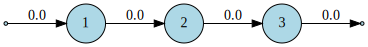

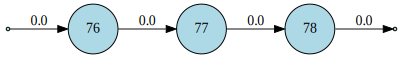

In [12]:
function makehmm(pdfidxs)
    fsm = FSM()
    prevstate = initstate(fsm)
    for pdfidx in pdfidxs
        state = addstate!(fsm, pdfindex = pdfidx)
        
        # We don't add the self loop here as it will be
        # removed by the minimization algorithms

        link!(fsm, prevstate, state)
        prevstate = state
    end
    link!(fsm, prevstate, finalstate(fsm))
    fsm |> weightnormalize!
end

hmms = Dict{Label, FSM}()
for (i, l) in enumerate('a':'z')
    startidx = 3 * (i -1) + 1
    hmms["$l"] = makehmm([startidx, startidx + 1, startidx + 2])
end
display(hmms["a"])
display(hmms["z"])

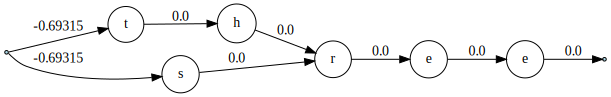

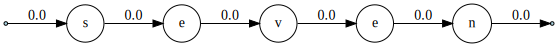

In [13]:
spelling = Dict(
    "zero"  => [("z", "e", "r", "o")],
    "one"   => [("o", "n", "e")],
    "two"   => [("t", "w", "o")],
    "three" => [("t", "h", "r", "e", "e"),
                ("s", "r", "e", "e")],  # French pronunciation 😁
    "four"  => [("f", "o", "u", "r")],
    "five"  => [("f", "i", "v", "e")],
    "six"   => [("s", "i", "x")],
    "seven" => [("s", "e", "v", "e", "n")],
    "eight" => [("e", "i", "g", "h", "t")],
    "nine"  => [("n", "i", "n", "e")]
)

function makepronunciation(pronunciation)
    fsm = FSM()
    prevstate = initstate(fsm)
    for letter in pronunciation
        state = addstate!(fsm, label = letter)
        link!(fsm, prevstate, state)
        prevstate = state
    end
    link!(fsm, prevstate, finalstate(fsm))
    fsm
end

lexicon = Dict{Label, FSM}()
for (word, pronunciations) in spelling
    lexicon[word] = union(makepronunciation.(pronunciations)...) |> minimize!
end

display(lexicon["three"])
display(lexicon["seven"])

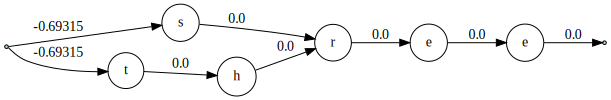

In [14]:
test = deepcopy(lexicon["three"])
test |> weightnormalize!

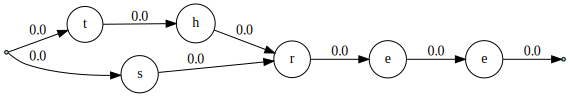

In [15]:
test = deepcopy(lexicon["three"])
determinize!(test)

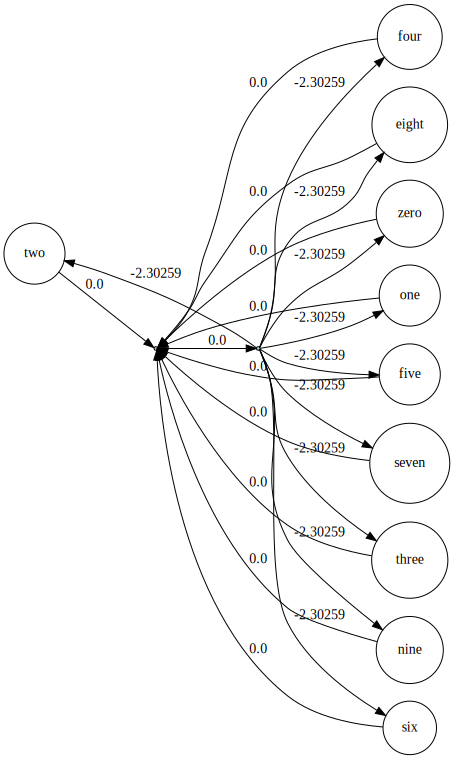

In [16]:
words = keys(lexicon)

# Create a simple unigram language model
lm = FSM()
for word in keys(lexicon)
    s = addstate!(lm, label = word)
    link!(lm, initstate(lm), s)
    link!(lm, s, finalstate(lm))
end

link!(lm, finalstate(lm), initstate(lm))
lm = lm |> weightnormalize!

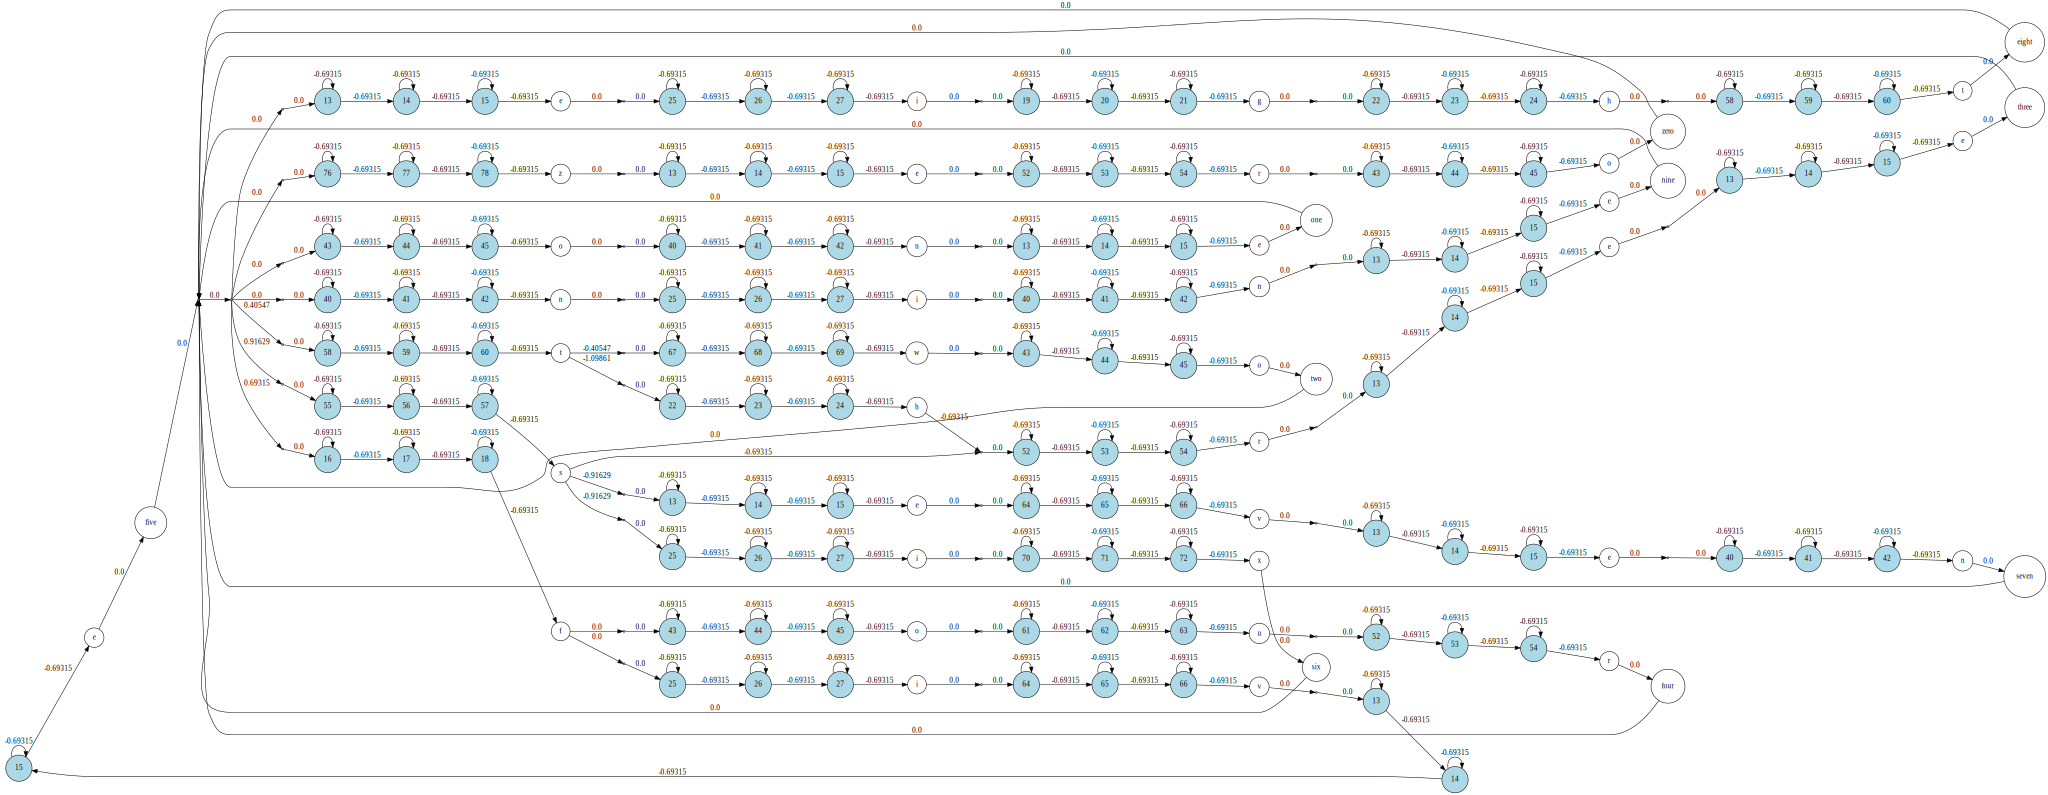

In [17]:
decoder = compose!(compose!(lm, lexicon) |> minimize!, hmms) |> addselfloop!

In [18]:
emissionsmap = Dict(
    "a" => 1,
    "b" => 2,
    "c" => 3,
    "d" => 4
)

fsm = FSM()
s1 = addstate!(fsm, pdfindex = 1)
s2 = addstate!(fsm, pdfindex = 2)
s3 = addstate!(fsm, pdfindex = 3)

link!(fsm, initstate(fsm), s1)
link!(fsm, s1, s2)
link!(fsm, s2, s3)
link!(fsm, s3, finalstate(fsm))

1-element Array{Link,1}:
 Link{Float64}(State(finalstateid), State(3, pdfindex = 3), 0.0)

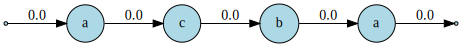

In [19]:
fsm1 = LinearFSM(["a", "c", "b", "a"], emissionsmap)

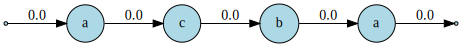

In [20]:
deepcopy(fsm1) |> determinize!

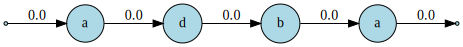

In [21]:
fsm2 = LinearFSM(["a", "d", "b", "a"], emissionsmap)

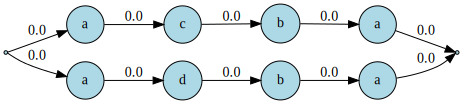

In [22]:
fsm = union(fsm1, fsm2)
fsm

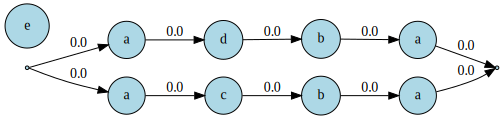

In [23]:
addstate!(fsm, pdfindex = 10, label = " e") # add unreachable state
fsm

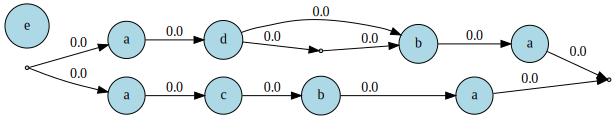

In [24]:
# Add useless connection
tmp = addstate!(fsm)
link!(fsm, fsm.states[6], tmp)
link!(fsm, tmp, fsm.states[7])
fsm

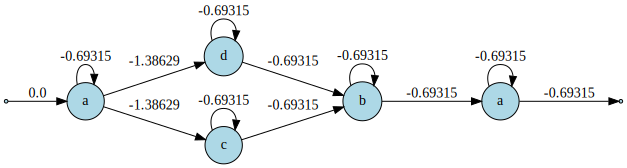

In [25]:
fsm = fsm |> minimize! |> addselfloop!

In [26]:
D,N = 4, 10 # number of distributions times number of frames
v = randn(N, 1) .- 6 
llh = repeat(v', D)

4×10 Array{Float64,2}:
 -5.84206  -7.86174  -6.41767  -5.07328  …  -6.25573  -5.68133  -6.24275
 -5.84206  -7.86174  -6.41767  -5.07328     -6.25573  -5.68133  -6.24275
 -5.84206  -7.86174  -6.41767  -5.07328     -6.25573  -5.68133  -6.24275
 -5.84206  -7.86174  -6.41767  -5.07328     -6.25573  -5.68133  -6.24275

In [27]:
llh = zeros(4,5)

4×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [28]:
llh[:,1:2] .= [1, 0.5, 0, 0]
llh[:,3:4] .= [0.5, 1, 0.5, 0]
llh[:,5:5] .= [0, 0.5, 1, 0.5]
llh

4×5 Array{Float64,2}:
 1.0  1.0  0.5  0.5  0.0
 0.5  0.5  1.0  1.0  0.5
 0.0  0.0  0.5  0.5  1.0
 0.0  0.0  0.0  0.0  0.5

In [35]:
α = αrecursion(fsm, llh; pruning = nopruning) # the lower the more pruning 
α

[n = 1]  	22	22 = 1.000  
[n = 2]  	22	20 = -0.386  	21 = -0.386  	22 = 1.307  
[n = 3]  	19	19 = 1.234  	20 = 1.122  	21 = 0.234  	22 = 1.114  
[n = 4]  	19	18 = 1.041  	19 = 3.862  	20 = 1.526  	21 = 0.332  	22 = 0.921  
[n = 5]  	19	18 = 3.227  	19 = 4.736  	20 = 2.388  	21 = 1.049  	22 = 0.227  


In [36]:
β = βrecursion(fsm, llh; pruning = nopruning) # the lower the more pruning 
β

[n = 1]  	22	18 = -0.773  	19 = 2.062  	20 = 3.006  	21 = 3.654  	22 = 4.283  
[n = 2]  	21	18 = -1.079  	19 = 1.987  	20 = 2.794  	21 = 3.373  	22 = 2.988  
[n = 3]  	21	18 = -0.886  	19 = 1.474  	20 = 1.693  	21 = 2.386  
[n = 4]  	19	18 = -0.693  	19 = 0.693  
[n = 5]  	18	18 = 0.000  


In [37]:
lnαβ, tll = αβrecursion(fsm, llh) # the lower the more pruning 
lnαβ

[n = 1]  	22	22 = 0.000  
[n = 2]  	22	20 = -2.238  	21 = -1.659  	22 = -0.352  
[n = 3]  	20	19 = -1.108  	20 = -1.001  	21 = -1.196  
[n = 4]  	19	18 = -4.222  	19 = -0.015  
[n = 5]  	18	18 = 0.000  


State[State(18, pdfindex = 1, label = a)]
[3.9196725511550667]
-----
State[State(19, pdfindex = 2, label = b), State(18, pdfindex = 1, label = a)]
[5.2481355025542875, 1.0406729652784419]
-----
State[State(19, pdfindex = 2, label = b), State(20, pdfindex = 3, label = c), State(21, pdfindex = 4, label = d)]
[2.9269673263983327, 3.5082660974228075, 3.3132616875182226]
-----
State[State(22, pdfindex = 1, label = a), State(20, pdfindex = 3, label = c)]
[4.193147180559945, 1.8068528194400548]
-----
State[State(22, pdfindex = 1, label = a)]
[4.193147180559945]
-----


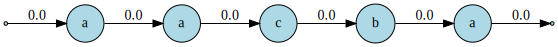

In [45]:
path = viterbi(fsm, llh)